# Laboratory 2 : Computer Vision

# Part 1: MNIST Digist Classification

In the first portion of this lab, we will build and train a convolutional neural network (CNN) for classification of handwritten digits from the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Our classes are the digits 0-9.

We'll use the [`InteractiveSession`](https://www.tensorflow.org/api_docs/python/tf/InteractiveSession) class to make debugging easier, since it does not require TensorFlow to build a complete computation graph before testing the code.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import random

sess = tf.InteractiveSession()

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1.1 MNIST Dataset 

We first download and load the dataset and display a few random samples from it.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


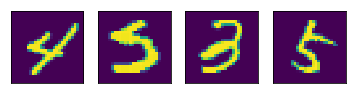

In [3]:
random_indices = [random.randint(0,50000) for x in range(5)]

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow((mnist.train._images[random_indices[i]].reshape(28,28)))
    plt.xticks([]) 
    plt.yticks([])

We define placeholders for our input data `x` and the corresponding labels `y`:

In [4]:
# placeholders for data (x) and labels (y)
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])

## 1.2 CNN for Handwritten Digit Classification

We will build a CNN composed of two convolutional and pooling layers, followed by two fully connected layers, and ultimately output a probability distribution over the 10 digit classes (0-9). The CNN we will be building is depicted below.

![alt_text](img/mnist_model.png "CNN Architecture for MNIST Classification")

First, we must [reshape](https://www.tensorflow.org/api_docs/python/tf/reshape) our input from a 784-dimensional input to a 4-D blob that preserves the spatial nature of the image. 

In [5]:
x_input = tf.reshape(x, [-1, 28, 28, 1])

Note how we assign the special value of -1 to the first component of the shape. This means that the size of that dimension is computed so that the total size (number of dimensions of the input, 784 in this case) remains constant.

### 1.2.1 CNN Architecture
Now we can start defining the architecture of our CNN using the [`tf.layers`](https://www.tensorflow.org/api_docs/python/tf/layers) API:

In [6]:
# first convolutional layer
# 32 5x5 filters with stride of 1, ReLU activation
conv1 = tf.layers.conv2d(inputs=x_input, filters=32, kernel_size=[5,5], activation=tf.nn.relu)
# first pooling layer
# 2x2 max pooling with stride of 2
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=[2,2])

In [7]:
# second convolutional layer
'''TODO: define a convolutional layer with 48 5x5 filters with stride of 1, ReLU activation'''
conv2 = tf.layers.conv2d(inputs=pool1, filters=48, kernel_size=[5,5], activation=tf.nn.relu) #TODO
# second pooling layer
'''TODO: define a 2x2 max pooling layer with stride of 2'''
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=[2,2]) #TODO

We've used the [`tf.layers`](https://www.tensorflow.org/api_docs/python/tf/layers) API to build convolutional layers for feature extraction. Now, we can define fully connected layers to complete the handwritten digit classification task. 

Let's take a step back and consider the dimensionality of the output of the last max pooling operation. The number of nodes in a feature map after a convolution or pooling operation is given by:<br><br>
$$
n = \Big(\frac{(d-i+2p)}{s}+1\Big) \times \Big(\frac{(d-i+2p)}{s}+1\Big)
$$
<br><br>
where $d$ is the dimension of the input to that layer, $i$ is the dimension of the filter we apply, $p$ is the padding, and $s$ is the stride. In our case, $p=0$. For convolutional layers, $i=5, s=1$, and for pooling layers, $i=2, s=2$. It is a useful exercise to go through these calculations:

In [8]:
'''TODO: Determine the dimensionality of the feature maps after each convolution and max pooling operation'''
# Conv layer 1: 24x24 nodes per feature map, 32 feature maps
# Max pooling 1: 12x12 nodes per feature map, 32 feature maps
# Conv layer 2: 8x8 nodes per feature map, 48 feature maps
# Max pooling 2: 4x4 nodes per feature map, 48 feature maps
input_height = 28
conv1_height = (input_height - 5 + 2*0) + 1
pool1_height = conv1_height / 2
conv2_height = (pool1_height - 2 + 2*0)/2 + 1 #TODO
pool2_height = conv2_height / 2 #TODO

We will [flatten](https://www.tensorflow.org/api_docs/python/tf/layers/flatten) the final feature maps before feeding as input into the first fully connected layer:

In [9]:
flat = tf.layers.flatten(pool2)

The first fully connected layer will have 512 units and ReLU activation. We can then pass on its output as input to the final fully connected layer and output class probabilities:

In [10]:
# pass flattened input into the first fully connected layer
fc1 = tf.layers.dense(inputs=flat, units=512, activation=tf.nn.relu)
# define second fully connected layer for 0-9 digit classification
'''TODO: define the second fully connected layer. Think about the number of units you need.'''
y_pred = tf.layers.dense(inputs=fc1, units=10) #TODO

# output probabilities of input image belonging to each digit class
'''TODO: compute output probabilities for the predicted labels. What activation function should you use?'''
probabilities = tf.nn.softmax(y_pred) #TODO

That defines our model! Now we can move on to defining the loss function we will optimize during training and the training itself.

### 1.2.2 Loss Function and Class Prediction

We can use mean cross entropy as our loss function as this is a multi-class classification problem:

In [11]:
# calculate mean cross entropy over entire batch of samples. 
'''TODO: write a TensorFlow expression for computing the mean cross entropy loss over the entire batch of samples.
Hint: consider tf.nn.softmax_cross_entropy_with_logits_v2 and pay close attention to the online documentation 
and logits input! Remember that this function expects probabilities before the softmax'''
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_pred))#TODO

Next, we specify the optimizer (Adam) and the learning rate (`1e-3`). We also calculate the average accuracy.

In [12]:
optimizer = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Finally, we obtain the predicted class:

In [13]:
prediction=tf.argmax(y_pred,1)

**Tensorboard** is a tool to automatically plot and visualize the training process. You can periodically send "summaries" such as: 
* scalars (loss, accuracy, ...)
* images (photos, heatmaps, ...)
* distributions (weights, biases, activations, ...)

Let's set some simple scalar summaries to be plotted on Tensorboard (http://localhost:6006) - the plotting code below occurs during training.

In [14]:
tf.summary.scalar('loss',cross_entropy) 
tf.summary.scalar('acc',accuracy)

merged_summary_op = tf.summary.merge_all() #combine into a single summary which we can run on Tensorboard

### 1.2.3 Training!

Now that we have defined our network architecture and optimization criteria, we are ready to train and evaluate our CNN on the MNIST dataset! 

For this, we create an instance of `tf.Session()`, and initialize variables within the session. We set the number of iterations for optimization to 200. Additionally, we will plot the evolution of performance (accuracy) over the course of training and the final [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

100%|██████████| 200/200 [00:14<00:00, 14.13it/s]


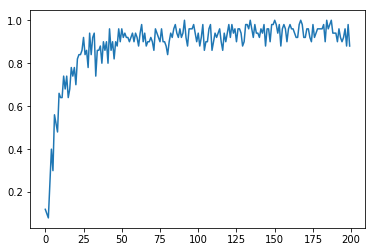

In [ ]:
import uuid
num_iterations = 200
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    uniq_id = "./logs/lab2part1_"+uuid.uuid1().__str__()[:6]
    summary_writer = tf.summary.FileWriter(uniq_id, graph=tf.get_default_graph())
    training_perf = []
    for i in tqdm.tqdm(range(num_iterations)):
        batch = mnist.train.next_batch(50)

        feed_dict = {x: batch[0], y: batch[1]}
        (_, train_accuracy, summary) = sess.run([optimizer,accuracy, merged_summary_op], feed_dict=feed_dict)
        training_perf.append(train_accuracy)
        summary_writer.add_summary(summary, i) 

    # now plotting the variation of training performance
    plt.plot(range(num_iterations), training_perf)
    plt.show()
    
    # we now evaluate the validation accuracy
    print('Validation accuracy: %g' % accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))
    
    # we now plot the confusion matrix on the validation accuracy
    preds = prediction.eval(feed_dict={x: mnist.test.images})
    conf_mat = tf.contrib.metrics.confusion_matrix(labels=tf.argmax(mnist.test.labels,1), predictions=preds, num_classes=10)
    plt.imshow(conf_mat.eval())

To run and visualize the results run the code below to launch tensorboard. Click "i" to interupt and cancel when you're done

In [ ]:
!tensorboard --logdir='./logs/'

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
TensorBoard 1.5.0a20180127 at http://9a29e5d65d73:6006 (Press CTRL+C to quit)


The code above trains the model and print the accuracy on the test set at the end of optimization. This network should produce an accuracy of ~95%. To increase this value, you can try applying some of the techniques you learned in Lecture 1, such as:

- Using dropout in the first fully connected layer (hint: use `tf.nn.dropout` and select a good value of the dropout ratio).
- Adding extra layers to the network, and tuning the hyperparameters of the network architecture (i.e., number and dimension of filters).
- Decreasing the learning rate as training progresses.